In [1]:
!pip install PyALE

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, pickle
from scipy.interpolate import make_interp_spline, BSpline
from PyALE import ale
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [3]:
with open('/content/drive/MyDrive/ModeChoice/data_org.pkl', 'rb') as file:
  data_ = pickle.load(file)

In [4]:
def get_income(row):
    for c in data_.loc[:, ['low_income', 'middle_income', 'high_income']].columns:
        if row[c]==1:
            return c
dframe = data_.copy(deep=True)
dframe['income'] = dframe.loc[:, ['low_income', 'middle_income', 'high_income']].apply(get_income, axis = 1)

dframe.drop(labels=['low_income', 'middle_income', 'high_income'], axis = 1, inplace=True)

gender_dic = {0:'female', 1:'male'}
driving_dic = {0:'no', 1:'yes'}

dframe.replace({'gender':gender_dic, 'driving_license':driving_dic}, inplace = True)

In [5]:
numerical_columns = ['travel_time', 'household_size', 'age', 'car_own', 'bicycle_own', 'link_node_ratio', 'dist_tran_stop',
          'diversity', 'job_hh_ratio', 'pop_density', 'emp_density',
          'dest_link_node_ratio', 'dest_dist_tran_stop', 'dest_diversity', 'dest_job_hh_ratio',
          'dest_pop_density', 'dest_emp_density']
categorical_columns = ['gender','driving_license', 'income']

rs = 42

X=dframe[numerical_columns+categorical_columns]
y=dframe['mode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')

scaler = MinMaxScaler()

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
    ('num', scaler, numerical_columns)])


In [ ]:
# clf_rf = RandomForestClassifier(class_weight={1: 5, 2: 1, 3: 1}, criterion='entropy',
#                        max_depth=20, n_estimators=500, n_jobs=-1,
#                        random_state=4)
# clf_rf.fit(X_train, np.ravel(y_train))

In [6]:
classifier = RandomForestClassifier(class_weight={1: 5, 2: 1, 3: 1}, criterion='entropy',
                       max_depth=20, n_estimators=500, n_jobs=-1,
                       random_state=4)

clf_rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', classifier)
])
result = clf_rf.fit(X_train, y_train)

In [7]:
class clf_dummy():
    def predict(df):
        return(clf_rf.predict_proba(df)[:, 0])

In [8]:
labels = ['Travel time', 'Household Size', 'Age', 'No. of Car Owned', 'No. of Bicycle Owned',
            'Link node ratio', 'Distance to Transit Stop (km)', 'Diversity', 'Job-to-HH ratio (jobs/HH)',
            'Population Density (HH/hectare)', 'Employment Density (jobs/hectare)','Destination Link node ratio',
            'Destination Distance to Transit Stop (km)',
            'Destination Diversity', 'Destination Job-to-HH ratio (jobs/hh)',
            'Destination Population Density (HH/hectare)', 'Destination Employment Density (jobs/hectare)',
            'gender', 'driving_license', 'income']
car_res = [5,6,7,8,9,10]
car_work = [11,12,13,14,15,16]

# Origin

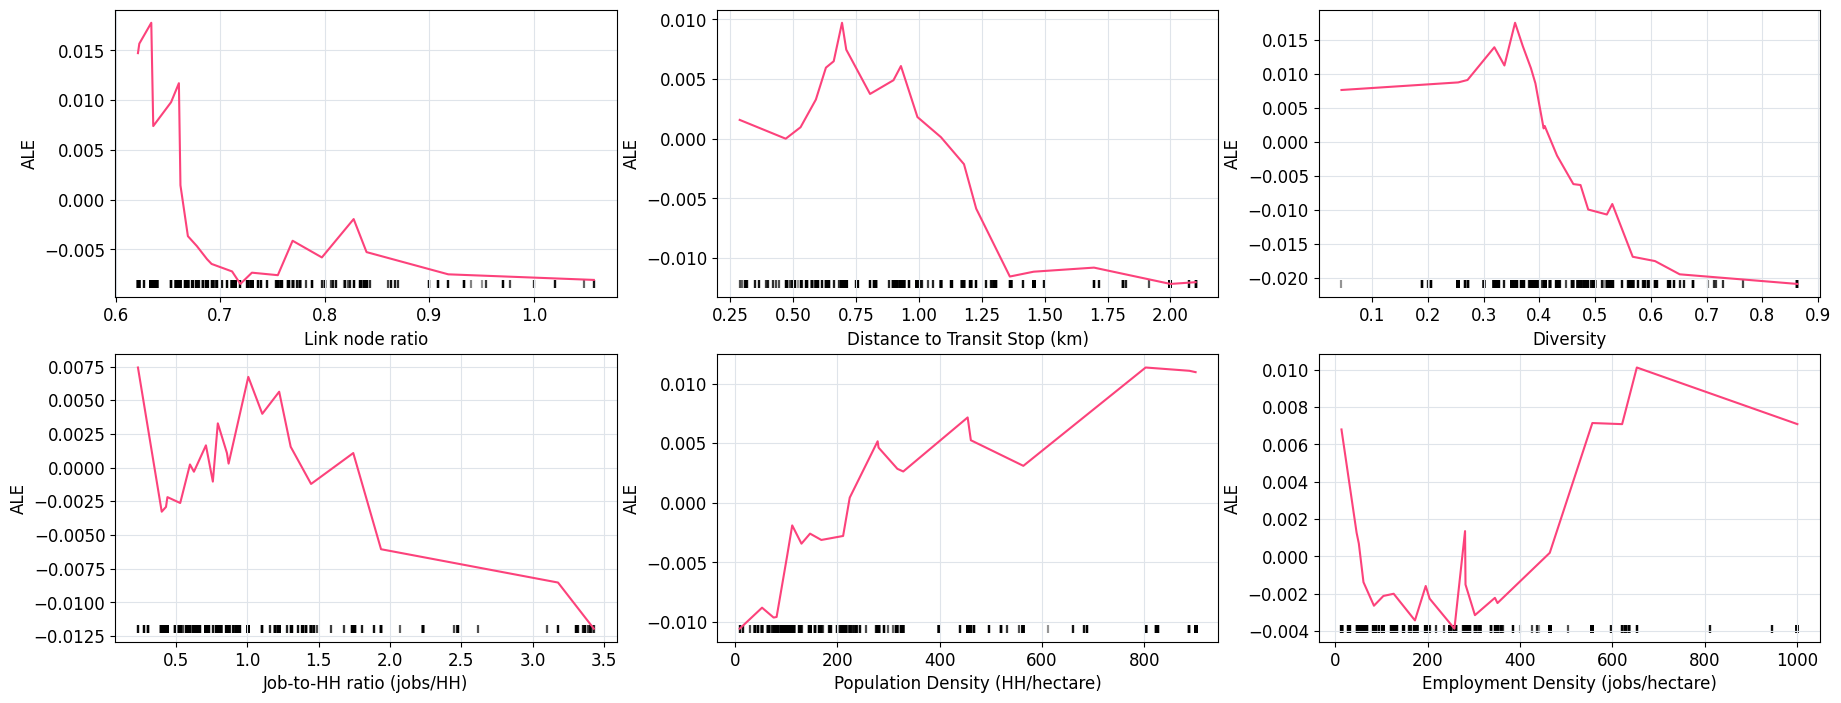

In [19]:
fig = plt.figure(figsize=(22, 8))
for idx, feat_idx in enumerate(car_res):
  ax = fig.add_subplot(2, 3, idx+1)
  ale_res = ale(X=X_train, model=clf_dummy, feature=[X_train.columns[feat_idx]], feature_type="continuous", grid_size=20, plot = False)
  ax.plot(ale_res['eff'], color='#FC427B')

  ax.scatter(X_train.iloc[:, feat_idx], np.zeros_like(X_train.iloc[:, feat_idx])+min(ale_res['eff']), color='k', marker='|', alpha=0.05)
  ax.set(xlabel=labels[feat_idx], ylabel='ALE',
       title='')
  ax.grid(color='#dfe4ea')
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.subplots_adjust(top=0.9)
plt.show()

# Destination

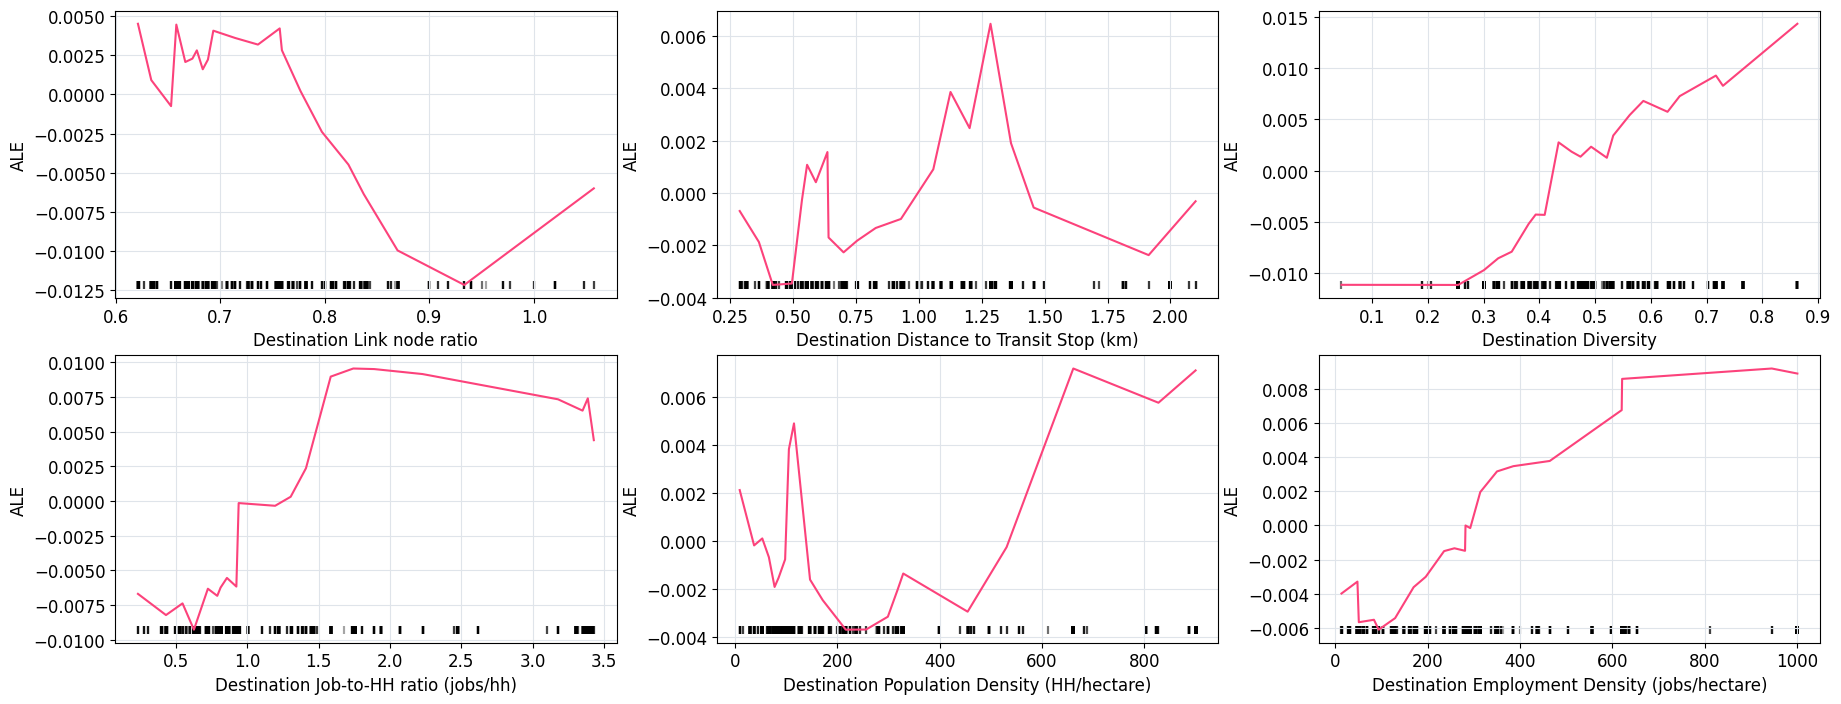

In [20]:
fig = plt.figure(figsize=(22, 8))
for idx, feat_idx in enumerate(car_work):
  ax = fig.add_subplot(2, 3, idx+1)
  ale_res = ale(X=X_train, model=clf_dummy, feature=[X_train.columns[feat_idx]], feature_type="continuous", grid_size=20, plot = False)
  ax.plot(ale_res['eff'], color='#FC427B')

  ax.scatter(X_train.iloc[:, feat_idx], np.zeros_like(X_train.iloc[:, feat_idx])+min(ale_res['eff']), color='k', marker='|', alpha=0.05)
  ax.set(xlabel=labels[feat_idx], ylabel='ALE',
       title='')
  ax.grid(color='#dfe4ea')
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

plt.subplots_adjust(top=0.9)
plt.show()

In [21]:
feature_combination =[(9,7),(9,10),(6,8), (15,11),(15,16),(14,16)]
feature_grid_res = [5, 4, 10, 10, 20, 10]

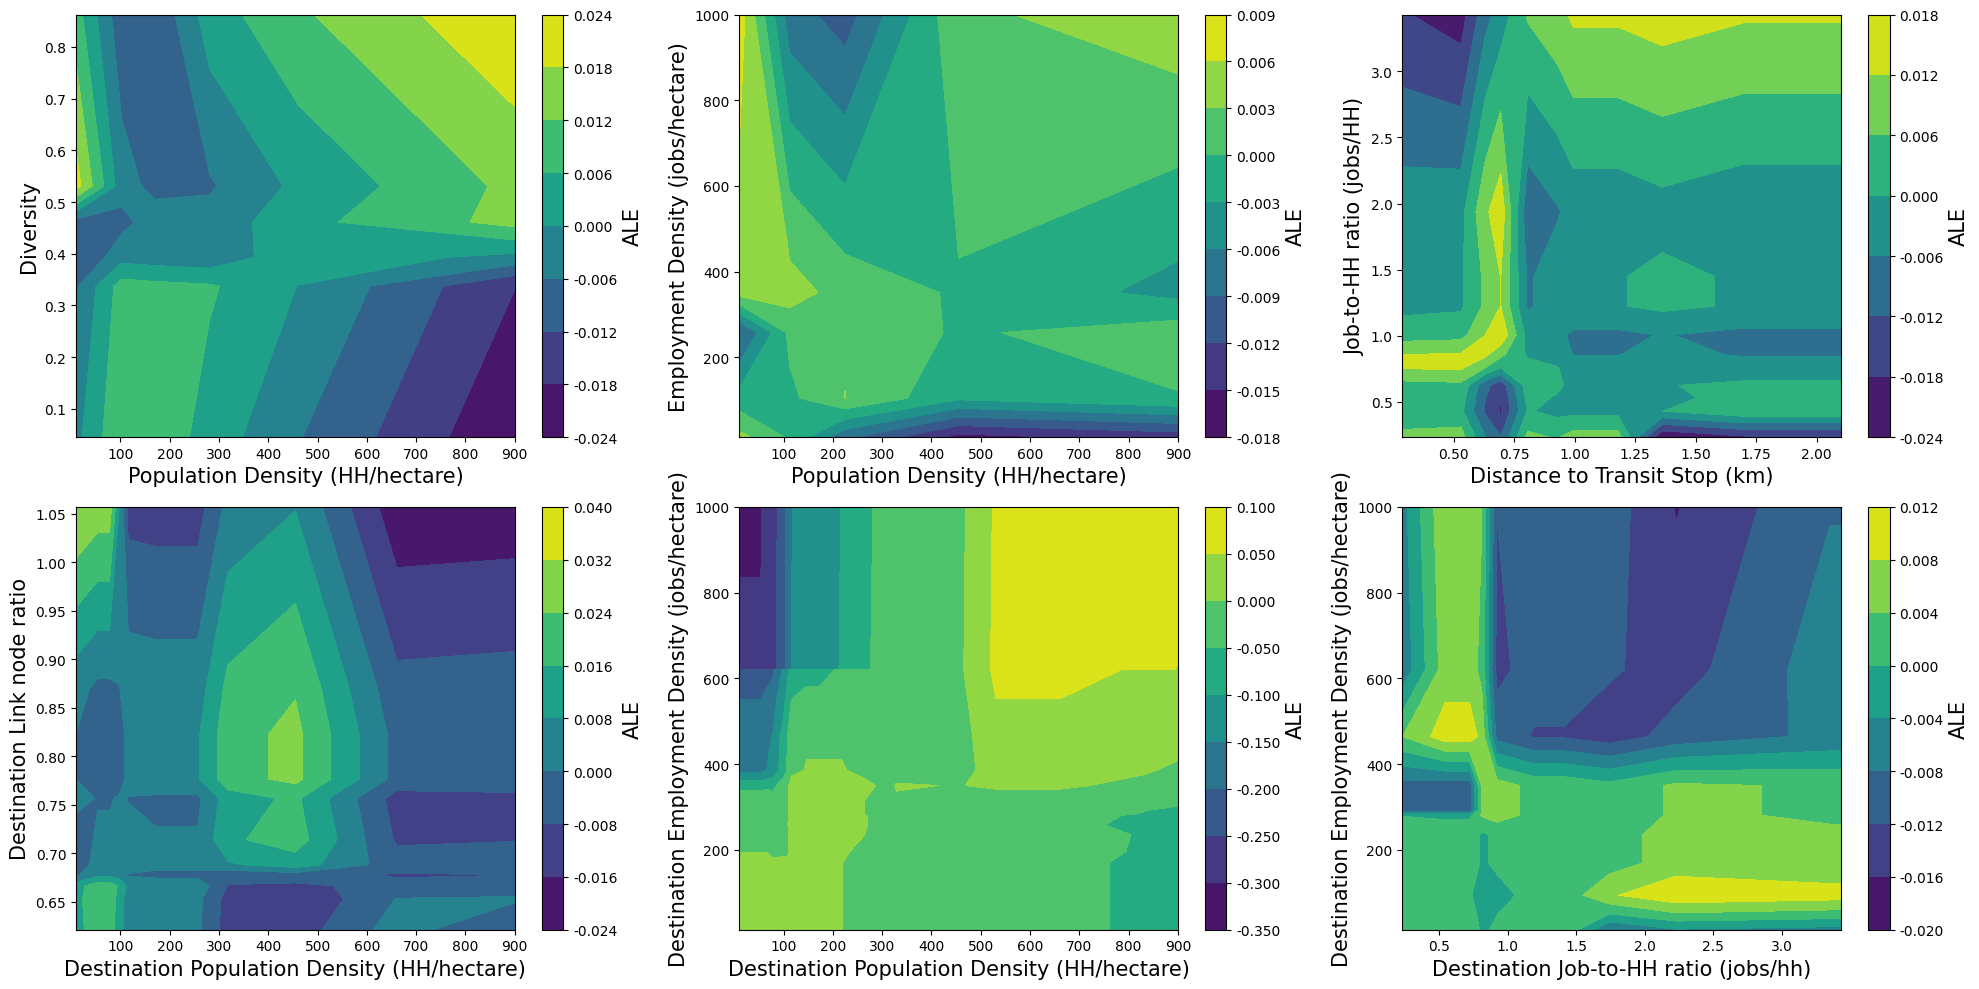

In [ ]:
aleGrids = []
for comb, res in zip(feature_combination, feature_grid_res):
  _mesh = ale(X=X_train, model=clf_rf, feature=[X_train.columns[comb[1]], X_train.columns[comb[0]]], plot=False, grid_size = res)
  aleGrids.append(_mesh)

fig = plt.figure(figsize=(20,10))

for i, _grid in enumerate(aleGrids):
  ax = fig.add_subplot(2,3,i+1)
  XX, YY = np.meshgrid(_grid.columns, _grid.index)
  Z = _grid
  surf = ax.contourf(XX, YY, Z)
  ax.set_xlabel(labels[feature_combination[i][0]], fontsize = 15)
  ax.set_ylabel(labels[feature_combination[i][1]], fontsize = 15)

  cbar = fig.colorbar(surf, format='%.3f')
  cbar.ax.set_ylabel('ALE', fontsize = 15)

plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()


In [43]:
destination_feature_combination = [(10,0),(8,0),(6,0),(6,3),(8,3),(5,3)]
destination_feature_grid_res = [15, 15, 10, 20, 15, 15]

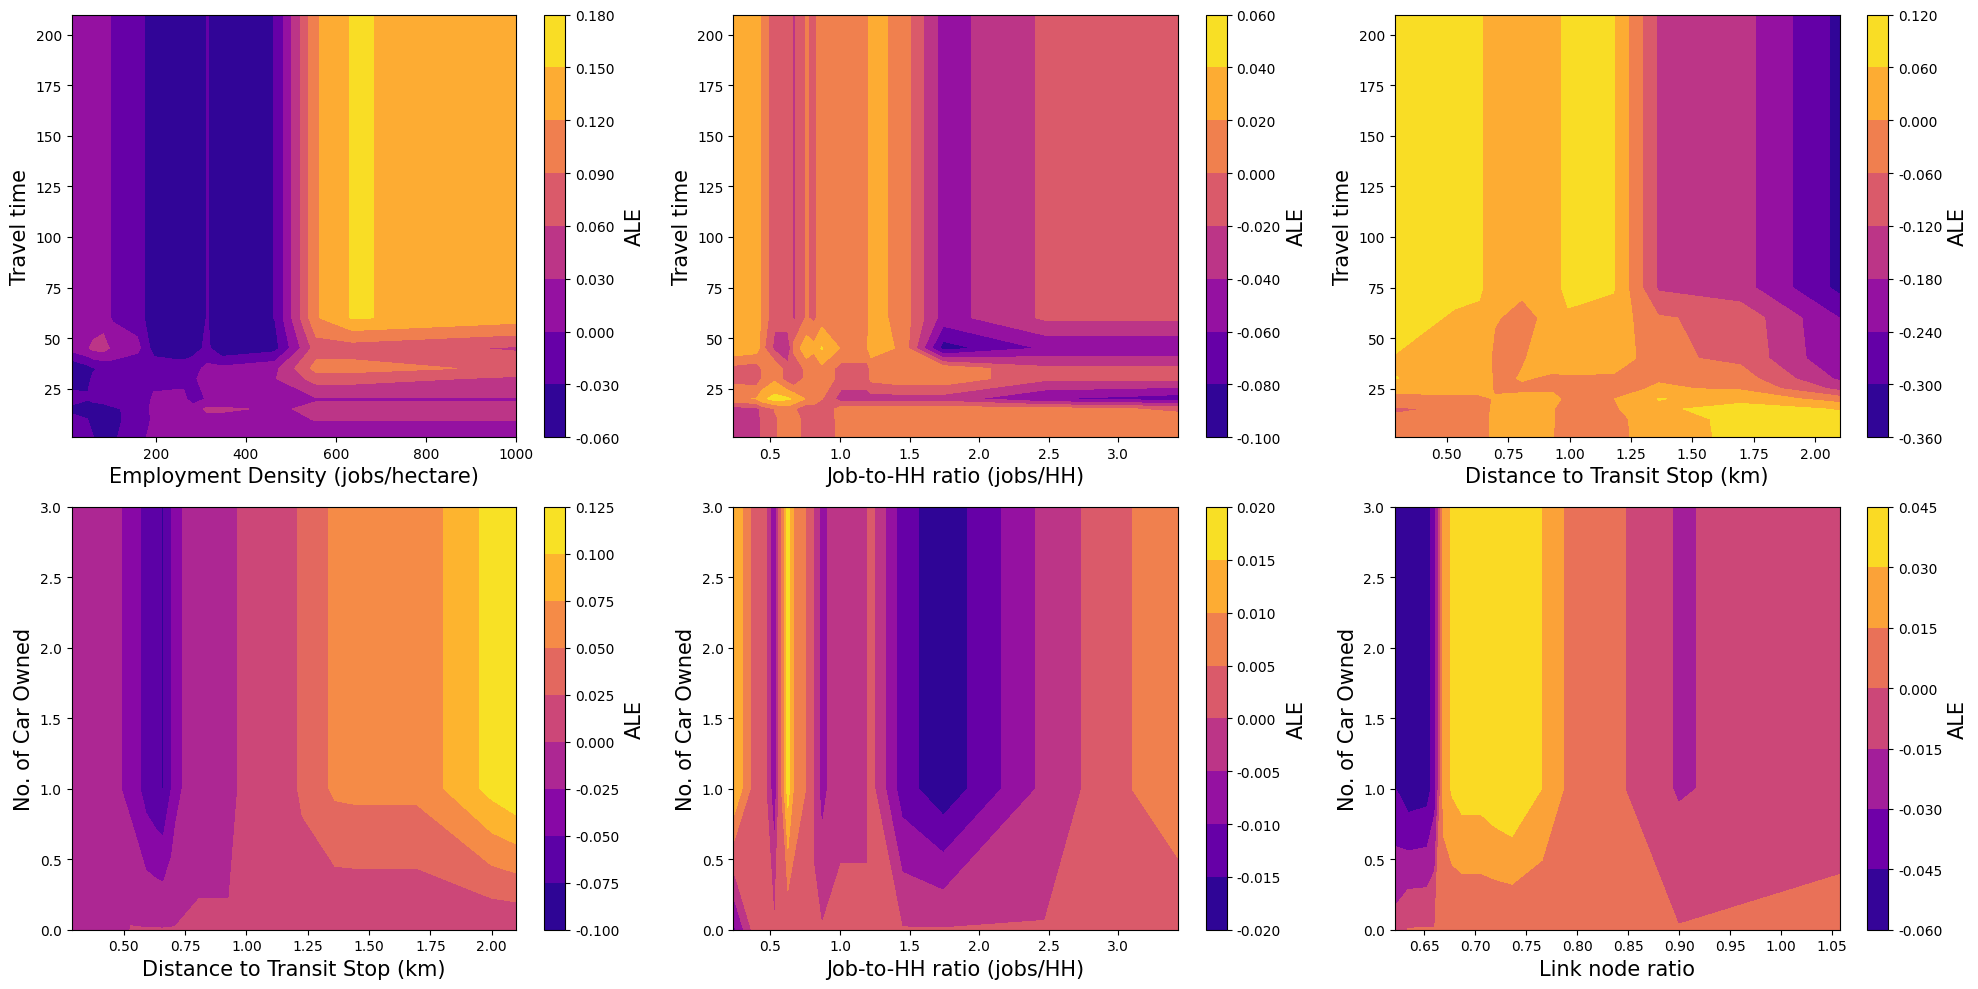

In [45]:
aleGrids = []
for comb, res in zip(destination_feature_combination, destination_feature_grid_res):
  _mesh = ale(X=X_train, model=clf_rf, feature=[X_train.columns[comb[1]], X_train.columns[comb[0]]], plot=False, grid_size = res)
  aleGrids.append(_mesh)

fig = plt.figure(figsize=(20,10))

for i, _grid in enumerate(aleGrids):
  ax = fig.add_subplot(2,3,i+1)
  XX, YY = np.meshgrid(_grid.columns, _grid.index)
  Z = _grid
  surf = ax.contourf(XX, YY, Z, cmap = 'plasma')
  ax.set_xlabel(labels[destination_feature_combination[i][0]], fontsize = 15)
  ax.set_ylabel(labels[destination_feature_combination[i][1]], fontsize = 15)

  cbar = fig.colorbar(surf, format='%.3f')
  cbar.ax.set_ylabel('ALE', fontsize = 15)

plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()
